# Mass Spring Damper System with PD Controller

## Import packages

In [1]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

## Define FeedbackControlSystem class
### System
Mass spring damper  
  
<img src="figs/mass_spring_damper.png" width="400" style="background-color:#FCFCFC;">

$$
m \ddot{x}_1 = - k x_1 - c \dot{x}_1 + u.\notag
$$
Let $\dot{x}_1 = x_2$. Then  
$$
\begin{align}
    \dot x = 
    \left[ \begin{array}{c}
    \dot{x}_1 \\
    \dot{x}_2 
    \end{array}\right]
    &= \left[ \begin{array}{cc}
    0 & 1\\
    -\frac{k}{m} & -\frac{c}{m}
    \end{array}\right]
    \left[ \begin{array}{c}
    x_1 \\
    x_2 
    \end{array}\right] + \left[ \begin{array}{c}
    0\\
    \frac{1}{m}
    \end{array}\right] u \notag \\
    &= Ax+Bu. \notag
\end{align}
$$

### Controller
PD controller
$$
\begin{align}
    u &= - k_p (x_1 - x_{1d}) - k_d \frac{d}{dt}(x_1 - x_{1d})\notag\\
      &= - k_p (x_1 - x_{1d}) - k_d x_2 \notag
\end{align}
$$
The objective is $x_1 \to x_d$ as $t \to \infty$. 

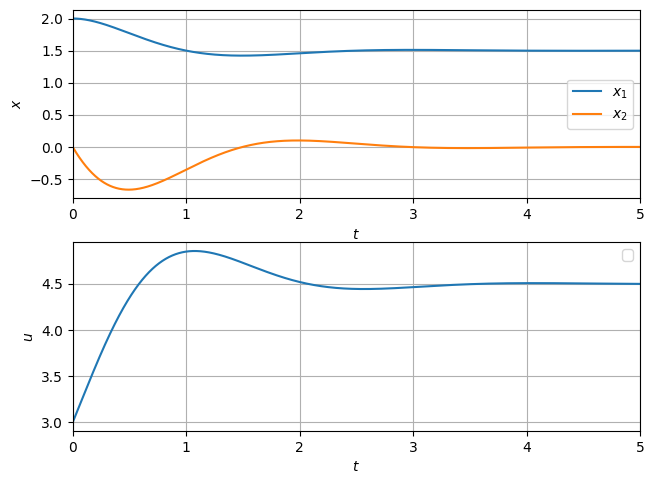

In [2]:
class FeedbackControlSystem:
    def __init__(self):
        self.name = 'mass_spring_damper-PD_controller'
        self.model_m = 1.
        self.model_c = 1.5
        self.model_k = 3.
        self.ctrl_xd = 3.
        self.ctrl_kp = 3.
        self.ctrl_kd = 1.
        self.sim_x0 = [2., 0.]
        self.sim_dt = 0.001
        self.sim_t_final = 5.
        self.sim_solver = 'RK45'

    def system(self, t, x):
        m = self.model_m
        c = self.model_c
        k = self.model_k
        A = np.array([
            [0, 1],
            [-k/m, -c/m]])
        B = np.array([[0], [1/m]])
        u = self.controller(x, t)
        dxdt = np.dot(A, x) + np.dot(B, u)
        return dxdt

    def controller(self, x, t):
        xd = self.ctrl_xd
        kp = self.ctrl_kp
        kd = self.ctrl_kd
        x1 = x[0]
        x2 = x[1]
        u = np.array([- kp*(x1 - xd) - kd*x2])
        return u

    def solve(self):
        x0 = self.sim_x0
        dt = self.sim_dt
        tf = self.sim_t_final
        solver = self.sim_solver

        self.ts = np.arange(0.0, tf+dt, dt)
        sol = solve_ivp(self.system, [0.0, tf], x0, solver, self.ts)
        self.xs = sol.y.T

        # Other sequences
        u0 = self.controller(x0, 0.0)
        dim_u = len(u0) if isinstance(u0, list) else 1
        s_qty = len(self.ts) # sequence quantity
        self.us = np.empty((s_qty,dim_u))
        for n in range(s_qty):
            self.us[n,:] = self.controller(self.xs[n,:], self.ts[n])

    def plot(self):
        fig, ax = plt.subplots(2,1)
        fig.tight_layout()
        # All states
        ax[0].plot(self.ts, self.xs)
        ax[0].set_xlabel('$t$')
        ax[0].set_ylabel('$x$')
        ax[0].set_xlim(0,self.sim_t_final)
        ax[0].legend([f"$x_{i+1}$" for i in range(self.xs.shape[1])])
        ax[0].grid()
        # All inputs
        ax[1].plot(self.ts, self.us)
        ax[1].set_xlabel('$t$')
        ax[1].set_ylabel('$u$')
        ax[1].set_xlim(0, self.sim_t_final)
        ax[1].legend(f"$u_{i+1}$" for i in range(self.us.shape[1]))
        ax[1].grid()
        # Show
        plt.show()

# confirm the class
fcs = FeedbackControlSystem()
fcs.solve()
fcs.plot()

## Parameter tuning

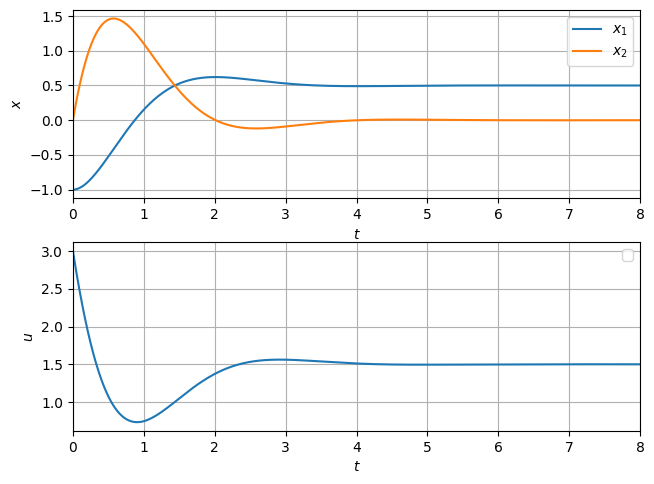

In [3]:
# Set parameters
fcs.model_m = 1.
fcs.model_c = 1.5
fcs.model_k = 3.
fcs.ctrl_xd = 2.
fcs.ctrl_kp = 1.
fcs.ctrl_kd = 1.
fcs.sim_x0 = [-1., 0.]
fcs.sim_dt = 0.001
fcs.sim_t_final = 8.
fcs.sim_solver = 'RK45'
# Solve and Plot
fcs.solve()
fcs.plot()

Iterative searches are also possible

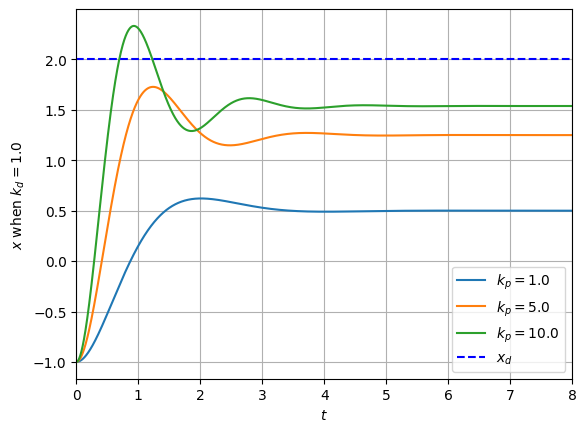

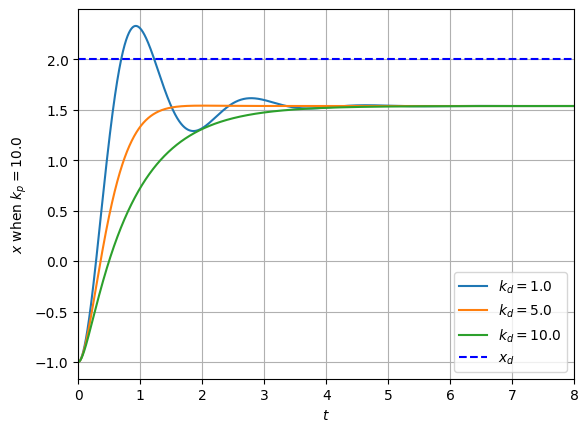

In [4]:
fig1 = plt.figure('for kp')
for kp in [1., 5., 10.]:
    fcs.ctrl_kp = kp
    fcs.solve()
    plt.plot(fcs.ts, fcs.xs[:,0], label=f'$k_p = {kp}$')

plt.hlines(fcs.ctrl_xd, 0, fcs.sim_t_final, 'blue', linestyles='dashed', label='$x_d$')
plt.legend()
plt.grid()
plt.xlabel('$t$')
plt.ylabel(f'$x$ when $k_d = {fcs.ctrl_kd}$')
plt.xlim(0, fcs.sim_t_final)

fig2 = plt.figure('for kd')
for kd in [1., 5., 10.]:
    fcs.ctrl_kd = kd
    fcs.solve()
    plt.plot(fcs.ts, fcs.xs[:,0], label=f'$k_d = {kd}$')

plt.hlines(fcs.ctrl_xd, 0, fcs.sim_t_final, 'blue', linestyles='dashed', label='$x_d$')
plt.legend()
plt.grid()
plt.xlabel('$t$')
plt.ylabel(f'$x$ when $k_p = {fcs.ctrl_kp}$')
plt.xlim(0, fcs.sim_t_final)

fcs.ctrl_kp = 10.
fcs.ctrl_kd = 5.
fcs.sim_t_final = 3.
fcs.solve()

## Visualization
If you just want to edit figures, it is better to skip the `solve` function.

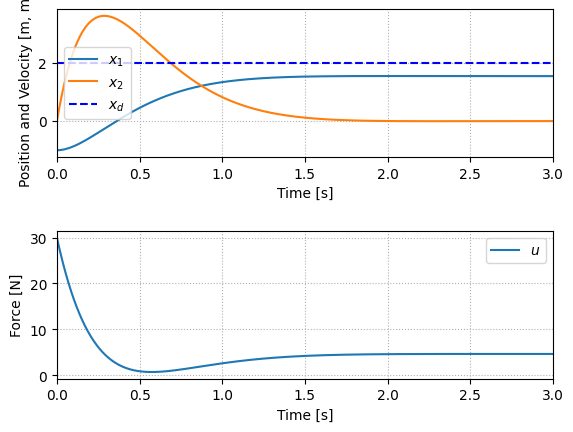

In [5]:
fig, ax = plt.subplots(2,1)
plt.subplots_adjust(hspace=0.5)
# State
ax[0].plot(fcs.ts, fcs.xs)
ax[0].hlines(fcs.ctrl_xd, 0, fcs.sim_t_final, 'blue', linestyles='dashed')
ax[0].set_xlabel('Time [s]')
ax[0].set_ylabel('Position and Velocity [m, m/s]')
ax[0].set_xlim(0,fcs.sim_t_final)
ax[0].legend(['$x_1$', '$x_2$', '$x_d$'])
ax[0].grid(ls=':')
# Input
ax[1].plot(fcs.ts, fcs.us)
ax[1].set_xlabel('Time [s]')
ax[1].set_ylabel('Force [N]')
ax[1].set_xlim(0, fcs.sim_t_final)
ax[1].legend(['$u$'])
ax[1].grid(ls=':')
# Show
plt.show()

## Reference
If you want readers to refer to papers, books or web sites.
- [NumPy](https://numpy.org/)
- [Scipy](https://scipy.org/)
- [Matplotlib](https://matplotlib.org/stable/)

## License
[MIT](https://github.com/kimushun1101/feedback-control-systems/blob/main/LICENSE)